In [ ]:
import pathlib
import os, shutil
import matplotlib.pyplot as plt
import random
import json

from PIL import Image, ImageOps
from IPython.display import Image as DImage

from keras import layers, models
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

from tensorflow.keras import optimizers
from tensorflow.keras.utils import load_img, img_to_array, array_to_img

from keras.applications.mobilenet_v2 import preprocess_input

In [ ]:
from keras.callbacks import Callback,ModelCheckpoint

In [ ]:
import numpy as np
import os
import tensorflow as tf

In [ ]:
import tensorflow_hub as hub

In [ ]:
from google.colab import drive
drive.mount('/content/drive')




Mounted at /content/drive


In [ ]:
from keras import backend as K

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



In [ ]:
class MobileNet(object):
    
    def __init__(self):       
        #инициализация модели
        num_classes = 7
        model_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
        inp = tf.keras.layers.Input((250, 250,3))
        resize_img = tf.keras.layers.Lambda(lambda image: tf.image.resize(image, (224,224)))

        feature_extractor_layer = hub.KerasLayer(model_url, trainable=False, 
                                                name="feature_extractor_layer", 
                                                input_shape=(224,224,3))
        self.model = models.Sequential([
                                    inp,
                                    resize_img,
                                    feature_extractor_layer, 
                                    tf.keras.layers.Dense(num_classes, 
                                                          activation="softmax", 
                                                          name="output_layer")
                                    ])

        #self.model  = models.Sequential()    
    
    #добавления слоя в модель
    def addlayer(self, layer):
        self.model.add(layer)

    #настройка модели
    def compileModel(self, loss, optimizer, metrics):
        self.model.compile(loss= loss, optimizer=optimizer, metrics=metrics)


    #загрузка преобученной модели
    def loadModel(self, pathToFile):
        self.model = load_model(pathToFile)
    
    #обучение
    def train(self, pathToFile, train_generator, validation_generator, steps_per_epoch, epochs, validation_steps,  batch_size, callbacks): #validation_steps,
        self.epochs = epochs
        self.history = self.model.fit(
            train_generator,
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            validation_data=validation_generator,
            validation_steps=validation_steps,
            batch_size=batch_size,
            callbacks=callbacks)
        self.model.save(pathToFile)
    
    def drawError(self):
      acc = self.history.history['acc']
      val_acc = self.history.history['val_acc']
      loss = self.history.history['loss']
      val_loss = self.history.history['val_loss']
      epochs = range(1, self.epochs + 1)
      plt.plot(epochs, acc, 'bo', label='Train acc')
      plt.plot(epochs, val_acc, 'b', label='Validation acc')
      plt.legend()
      plt.figure()

      plt.plot(epochs, loss, 'bo', label='Train loss')
      plt.plot(epochs, val_loss, 'b', label='Validation loss')
      plt.legend()
      plt.figure()

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (250, 250)

original_datasets_dir = os.path.join("drive/MyDrive", "handData")
picture  = os.path.join(original_datasets_dir, "cuts_full")

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
    )

train_generator = train_datagen.flow_from_directory(
    picture,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    picture, # same directory as training data
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation') # set as validation data


Found 103546 images belonging to 7 classes.
Found 25883 images belonging to 7 classes.


In [ ]:
train_generator.class_indices

{'call': 0, 'dislike': 1, 'like': 2, 'mute': 3, 'ok': 4, 'rock': 5, 'stop': 6}

In [ ]:
model = MobileNet()

In [ ]:
model

mobilenet_model = create_model(mobilenet_url, num_classes=7)
mobilenet_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])
history = mobilenet_model.fit(train_generator, epochs=5, steps_per_epoch=len(train_generator),
                              validation_data=validation_generator,validation_steps=len(validation_generator))

In [ ]:
loss='categorical_crossentropy'
optimizer="Adam"
metrics=['acc', recall_m, precision_m, f1_m]

In [ ]:
model.compileModel(loss, optimizer,metrics)


In [ ]:
callbacks = [ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/model_mobile.h5', save_best_only=True)]

In [ ]:
modelSavePath = os.path.join(pathlib.Path().resolve(),"/content/drive/MyDrive/Colab Notebooks/model_mobile.h5")
model.train(modelSavePath, 
                train_generator,
                validation_generator,
                steps_per_epoch=20,
                epochs=20,
                validation_steps=2,
                batch_size = 16,
                callbacks = callbacks) #50

Epoch 1/20
20/20 [==============================] - 275s 13s/step - loss: 1.8267 - acc: 0.3094 - recall_m: 0.1078 - precision_m: 0.4575 - f1_m: 0.1716 - val_loss: 1.2148 - val_acc: 0.6719 - val_recall_m: 0.2500 - val_precision_m: 0.9000 - val_f1_m: 0.3905
Epoch 2/20
20/20 [==============================] - 268s 13s/step - loss: 1.1318 - acc: 0.6203 - recall_m: 0.3594 - precision_m: 0.8029 - f1_m: 0.4921 - val_loss: 0.8247 - val_acc: 0.7812 - val_recall_m: 0.5469 - val_precision_m: 0.8759 - val_f1_m: 0.6730
Epoch 3/20
20/20 [==============================] - 266s 13s/step - loss: 0.8118 - acc: 0.7563 - recall_m: 0.5609 - precision_m: 0.9098 - f1_m: 0.6894 - val_loss: 0.7134 - val_acc: 0.6875 - val_recall_m: 0.5625 - val_precision_m: 0.9444 - val_f1_m: 0.7046
Epoch 4/20
20/20 [==============================] - 264s 13s/step - loss: 0.7055 - acc: 0.7656 - recall_m: 0.6359 - precision_m: 0.8885 - f1_m: 0.7385 - val_loss: 0.5836 - val_acc: 0.8125 - val_recall_m: 0.6719 - val_precision_m: 0.

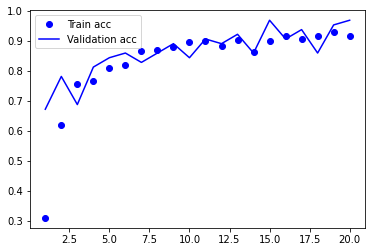

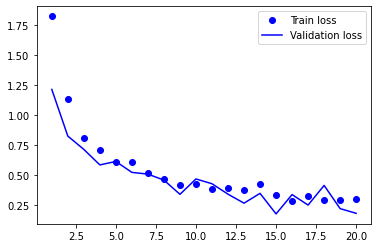

<Figure size 432x288 with 0 Axes>

In [ ]:
model.drawError()

<Figure size 432x288 with 0 Axes>

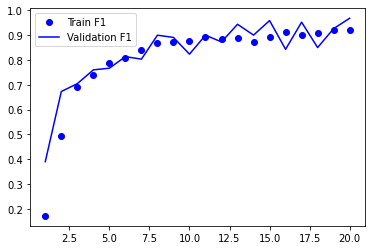

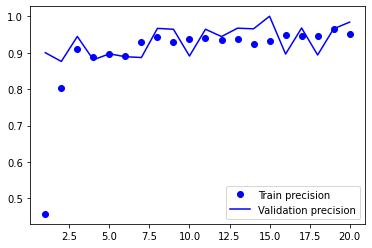

<Figure size 432x288 with 0 Axes>

In [ ]:
f_1 = model.history.history['f1_m']
val_f_1 = model.history.history['val_f1_m']
precision = model.history.history['precision_m']
val_precision = model.history.history['val_precision_m']
epochs = range(1, model.epochs + 1)
plt.plot(epochs, f_1, 'bo', label='Train F1')
plt.plot(epochs, val_f_1, 'b', label='Validation F1')
plt.legend()
plt.figure()

plt.plot(epochs, precision, 'bo', label='Train precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

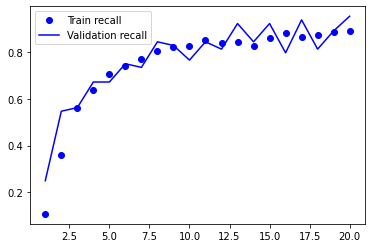

<Figure size 432x288 with 0 Axes>

In [ ]:
recall = model.history.history['recall_m']
val_recall = model.history.history['val_recall_m']
epochs = range(1, model.epochs + 1)
plt.plot(epochs, recall, 'bo', label='Train recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.legend()
plt.figure()


In [ ]:
original_datasets_dir = os.path.join("drive/MyDrive", "handData")
picture_test  = os.path.join(original_datasets_dir, "cuts_mini")

test_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
    )

test_generator = train_datagen.flow_from_directory(
    picture_test, # same directory as training data
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation') # set as validation data


Found 1109 images belonging to 7 classes.


In [ ]:
model.model.evaluate(test_generator,
    batch_size=None,
    verbose='auto',
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1)


35/35 [==============================] - 375s 11s/step - loss: 0.5156 - acc: 0.8115 - recall_m: 0.7722 - precision_m: 0.8700 - f1_m: 0.8177


[0.5156441330909729,
 0.8115419149398804,
 0.7721938490867615,
 0.8700230717658997,
 0.8177372217178345]